In [1]:
import json
import base64
import gzip
import os
import shutil
import pandas as pd
import copy
from pathlib import Path
from typing import Union
from collections import defaultdict

In [2]:
DATE='0527'

In [3]:
DRAW_COMMANDS = [
    "drawArrays",
    "drawElements",
    "drawArraysInstanced",
    "drawArraysInstancedANGLE",
    "drawElementsInstanced",
    "drawElementsInstancedANGLE",
    "drawRangeElements",
    "multiDrawArraysWEBGL",
    "multiDrawElementsWEBGL",
    "multiDrawArraysInstancedWEBGL",
    "multiDrawElementsInstancedWEBGL",
    "multiDrawArraysInstancedBaseInstanceWEBGL",
    "multiDrawElementsInstancedBaseVertexBaseInstanceWEBGL",
]

STATES = [
    "BlendState",
    "ColorState",
    "CoverageState",
    "CullState",
    "DepthState",
    "DrawState",
    "PolygonOffsetState",
    # "ScissorState",
    "StencilState",
    # "VisualState",
    "DrawCall",
]

PURGE_KEYS = [
    "STENCIL_BACK_REF",
    "STENCIL_REF",
    "BLEND_COLOR",
    "VIEWPORT",
    
    "value",
    "values",
    "src",
    "name",
    "bufferLength",
    "bufferSourceLength",
    "vertexAttrib",
    'displayText',
    "translatedSource",
    # "source",
    # 'name',
    # "bufferLength",
    # "bufferOffset",
    # "bufferSourceLength",
    # "offsetPointer",
]

In [4]:
def purge(co: Union[dict,list,int,str,float,bool,None]):
    if co is None:
        return None
    if isinstance(co, str):
        if co.startswith('data:') and 'base64' in co:
            return co.split(',')[0]
    if isinstance(co, (int, str, float, bool)):
        return co
    if isinstance(co, list):
        return [purge(x) for x in co]
    if isinstance(co, dict):
#         ret = {k: purge(v) for k, v in co.items() if k not in PURGE_KEYS and 'CommandId' not in k}
        ret = {k: purge(v) for k, v in co.items() if k not in PURGE_KEYS and not k.startswith("__SPECTOR") and 'CommandId' not in k}
        ret = {k: v for k, v in ret.items() if (not isinstance(v, (list, dict))) or (len(v) > 0)}
    return ret

In [5]:
# def get_duplicity_of_pipeline(obj):
#     possible_pipelines_set = defaultdict(lambda : { "pipeline": set(), "before": 0 })
#     for cmd in obj['commands']:
#         if cmd['name'] in DRAW_COMMANDS:
#             vv = purge({k: cmd[k] for k in STATES})
#             possible_pipelines_set[cmd['name']]["before"] += 1
#             possible_pipelines_set[cmd['name']]["pipeline"].add(json.dumps(vv, sort_keys=True, separators=(",", ":"), indent=None))
#     return [{"command": k, "pipelines": list(v["pipeline"]), "before": v["before"], "after": len(v["pipeline"])} for k, v in possible_pipelines_set.items()]

def get_duplicity_of_pipeline(obj):
    pipeline_set = defaultdict(int)
    bindgroup_set = defaultdict(int)
    vertexbuffer_set = defaultdict(int)
    for cmd in obj['commands']:
        if cmd['name'] in DRAW_COMMANDS:
            vv = purge({k: cmd[k] for k in STATES})
            pipeline_set[json.dumps(vv, sort_keys=True, separators=(",", ":"), indent=None)] += 1

            try:
                bindgroup_set[json.dumps(vv['DrawCall']['uniforms'], sort_keys=True, separators=(",", ":"), indent=None)] += 1
            except:
                pass

            try:
                vertexbuffer_set[json.dumps(vv['DrawCall']['attributes'], sort_keys=True, separators=(",", ":"), indent=None)] += 1
            except:
                pass
    # result['pipeline_after'] = len(result['pipeline'])
    # result['bindgroup_after'] = len(bindgroup_set)
    # result['vertexbuffer_after'] = len(vertexbuffer_set)
    # result['pipeline'] = list(result['pipeline'])
    # return result
    return {
        "pipeline": len(pipeline_set),
        "bindgroup": len(bindgroup_set),
        "vertexbuffer": len(vertexbuffer_set),
        # "pipeline_dict": dict(pipeline_set),
        # "bindgroup_dict": dict(bindgroup_set),
        # "vertexbuffer_dict": dict(vertexbuffer_set),
    }

In [6]:
if Path(f'imr/{DATE}-df_pipeline-merged.pkl.zst').exists():
    df_pipeline = pd.read_pickle(f'imr/{DATE}-df_pipeline-merged.pkl.zst', compression='zstd')
else:
    df = pd.read_pickle(f'imr/{DATE}-df_spector.pkl.zst', compression='zstd')
    df_a = df.copy()
    df_a['gl_version'] = df['frame.data'].str['context'].str['version']
    df_a['frame.data'] = df['frame.data'].map(get_duplicity_of_pipeline)
    df_b = df_a.drop(columns='frame.data').join(pd.json_normalize(df_a['frame.data']).add_prefix('frame.data.'))
    # df_b['frame.data.ratio'] = df_b['frame.data.after'] / df_b['frame.data.before']
    df_pipeline = df_b
    df_pipeline.to_pickle(f'imr/{DATE}-df_pipeline-merged.pkl.zst', compression='zstd')

In [7]:
df_pipeline = df_pipeline[df_pipeline['frame.data.pipeline'] >= 1]

In [8]:
df_pipeline

,idx-frame,idx,url,date,netIdleTimeout,spec_path,manual_interaction,frame.url,gl_version,frame.data.pipeline,frame.data.bindgroup,frame.data.vertexbuffer
0,0,00000,http://0ldsk00l.ca/,1683084643202,0,../2-9.playwright/output/spector-tmp/00000.json,NaN,http://0ldsk00l.ca/,2,1,1,1
1,53,00038,http://3d.halestormproductions.com/,1683084696384,0,../2-9.playwright/output/spector-tmp/00038.json,NaN,http://3d.halestormproductions.com/,1,3,3,3
2,54,00039,http://3d.kommunekart.com/,1684898343058,0,../2-9.playwright/output/spector-tmp/00039.json,True,http://3d.kommunekart.com/?x=51&y=9.9999999999...,1,8,7,4
3,55,00040,http://3d.metprof.ru/,1683084727016,0,../2-9.playwright/output/spector-tmp/00040.json,NaN,https://3d.metprof.ru/,1,13,11,8
4,56,00041,http://3d.morzh.eu/,1683084744788,0,../2-9.playwright/output/spector-tmp/00041.json,NaN,http://3d.morzh.eu/,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3845,111544,29191,https://zoccon.me/,1683202318068,0,../2-9.playwright/output/spector-tmp/29191.json,NaN,https://zoccon.me/,1,15,11,3
3846,111553,29195,https://zonanorte.27films.fr/,1683350201905,0,../2-9.playwright/output/spector-tmp/29195.json,NaN,https://zonanorte.27films.fr/,1,2,2,1
3847,111582,29209,https://zspkleszczow.pl/spacer-wirtualny,1683201858041,0,../2-9.playwright/output/spector-tmp/29209.json,NaN,https://zspkleszczow.pl/spacer-wirtualny/#node...,1,1,1,1
3848,111599,29217,https://zulu.longines.com/,1683347641637,0,../2-9.playwright/output/spector-tmp/29217.json,NaN,https://zulu.longines.com/,2,8,8,5


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=3)
# sns.set_palette("deep")
color_palette = sns.color_palette()
color_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

## Duplicity

In [36]:
df_pipeline[['gl_version', 'frame.data.pipeline', 'frame.data.bindgroup', 'frame.data.vertexbuffer']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,gl_version,frame.data.pipeline,frame.data.bindgroup,frame.data.vertexbuffer
count,3753.000000,3753.000000,3753.000000,3753.000000
mean,1.411937,5.667466,3.711431,3.138289
std,0.492249,16.437393,5.458471,11.770496
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,2.000000,1.000000
75%,2.000000,5.000000,4.000000,3.000000
90%,2.000000,12.000000,9.000000,4.000000
95%,2.000000,19.000000,14.000000,6.000000
99%,2.000000,57.440000,27.000000,30.480000


In [37]:
df_pipeline[df_pipeline['frame.data.pipeline']==0]

,idx-frame,idx,url,date,netIdleTimeout,spec_path,manual_interaction,frame.url,gl_version,frame.data.pipeline,frame.data.bindgroup,frame.data.vertexbuffer


In [38]:
# for idx,x in enumerate(df_pipeline.loc[3963]['frame.data.pipeline']):
#     with open(f"orig/{idx:05d}.json", 'w') as fp:
#         fp.write(x)

In [39]:
# df_pipeline.groupby('gl_version')[['frame.data.before', 'frame.data.after']].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

In [40]:
pipeline_df = pd.DataFrame({'Count': df_pipeline['frame.data.pipeline'], 'Component Name': 'pipeline', 'WebGL version': df_pipeline['gl_version']})
bindgroup_df = pd.DataFrame({'Count': df_pipeline['frame.data.bindgroup'], 'Component Name': 'bindgroup', 'WebGL version': df_pipeline['gl_version']})
vertexbuffer_df = pd.DataFrame({'Count': df_pipeline['frame.data.vertexbuffer'], 'Component Name': 'vertexbuffer', 'WebGL version': df_pipeline['gl_version']})
new_df = pd.concat([pipeline_df, bindgroup_df, vertexbuffer_df])
new_df

,Count,Component Name,WebGL version
0,1,pipeline,2
1,3,pipeline,1
2,8,pipeline,1
3,13,pipeline,1
4,1,pipeline,1
...,...,...,...
3845,3,vertexbuffer,1
3846,1,vertexbuffer,1
3847,1,vertexbuffer,1
3848,5,vertexbuffer,2


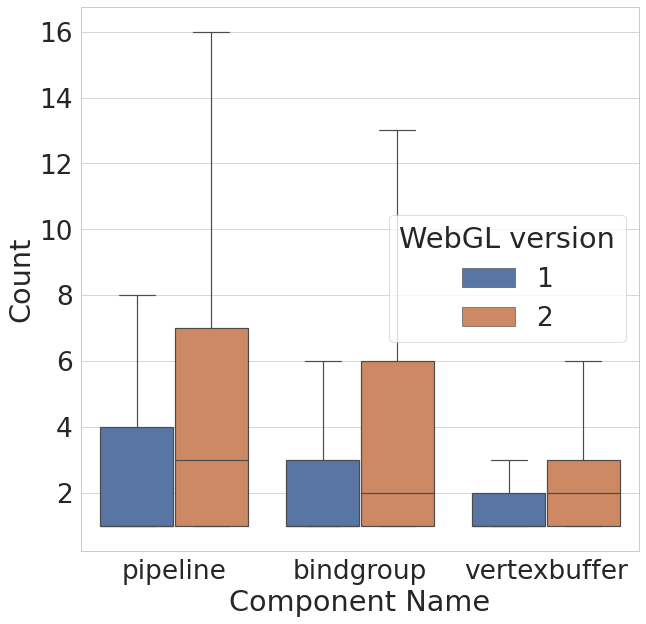

In [41]:
# fig, axes = plt.subplots(1, 2, figsize=(22,10))
plt.figure(figsize=(10,10))
sns.boxplot(new_df, x='Component Name', y='Count', hue='WebGL version', showfliers=False)
# axes[1].set_ylim((0,1))
# sns.boxplot(tmp, x='WebGL version', y='Ratio', ax=axes[1])
plt.savefig('fig/results_pipeline_duplication.pdf', bbox_inches='tight')

In [42]:
# sns.boxplot(df_pipeline[df_pipeline['frame.data.before']>1], x='frame.data.ratio', y='frame.data.command', hue='gl_version')
# plt.legend(bbox_to_anchor=(0.5, 1.5), borderaxespad=0, title='WebGL version', ncol=2, loc='upper center')

In [43]:
# plt.figure(figsize=(14, 10))
# sns.displot(df_c.reset_index(), x='frame.data.metric.value', hue='frame.data.metric.type', kind="ecdf")

## Complexity

### resources count in draw

In [44]:
# if Path("imr/0504-df_pipeline-detail.pkl.zst").exists():
#     df_pipeline_detail = pd.read_pickle("imr/0504-df_pipeline-detail.pkl.zst", compression='zstd')
# else:
#     df_a = df_pipeline.explode('frame.data.pipeline').dropna(subset='frame.data.pipeline')
#     df_a['frame.data.pipeline'] = df_a['frame.data.pipeline'].map(lambda x: json.loads(x))
#     df_pipeline_detail = df_a.drop(columns='frame.data.pipeline').join(pd.json_normalize(df_a['frame.data.pipeline'], max_level=0).add_prefix('frame.data.pipeline.'))
#     df_pipeline_detail.to_pickle("imr/0504-df_pipeline-detail.pkl.zst", compression='zstd')    

In [45]:
# df_pipeline_detail

### assemble distance

In [46]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
df_spector = pd.read_pickle(f'imr/{DATE}-df_spector.pkl.zst', compression='zstd')

In [48]:
# plot average_distance_between_draw
sns.set_context("paper", font_scale=2)
sns.set_palette("deep")
color_palette = sns.color_palette()
color_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [49]:
def get_distance_between_draw(x):
    cur = 0
    draws = 0
    lst = []
    for cmd in x['commands']:
        if cmd['name'] in DRAW_COMMANDS:
            lst.append(cur)
            cur = 0
            draws += 1
        else:
            cur += 1
    if cur > 0:
        lst.append(cur)
    if len(lst) == 0:
        return None
    return {
        'mean': np.mean(lst),
        'first': lst[0],
        # 'std': np.std(lst),
        'min': np.min(lst),
        'max': np.max(lst),
        'median': np.median(lst),
        # 'count': len(lst),
        'sum': np.sum(lst),
        # 'draws': draws,
        'max_ratio': np.max(lst) * draws / np.sum(lst),
        'first_ratio': lst[0] * draws / np.sum(lst),
        'first_over_max': lst[0] / np.max(lst),
    }

In [50]:
distance_between_draw = pd.json_normalize(df_spector['frame.data'].map(get_distance_between_draw))
distance_between_draw

,mean,first,min,max,median,sum,max_ratio,first_ratio,first_over_max
0,2.166667,4,2,4,2.0,26,1.846154,1.846154,1.000000
1,9.516667,82,6,82,9.0,1142,8.544658,8.544658,1.000000
2,12.632013,27,7,40,12.0,7655,3.161332,2.133899,0.675000
3,9.028169,11,3,31,8.0,641,3.433697,1.218409,0.354839
4,8.000000,24,7,24,7.0,136,3.000000,3.000000,1.000000
...,...,...,...,...,...,...,...,...,...
3845,16.000000,46,9,46,18.0,560,2.875000,2.875000,1.000000
3846,16.000000,24,3,24,21.0,48,1.000000,1.000000,1.000000
3847,8.897436,23,8,23,8.0,347,2.585014,2.585014,1.000000
3848,7.923077,27,1,27,5.0,103,3.407767,3.407767,1.000000


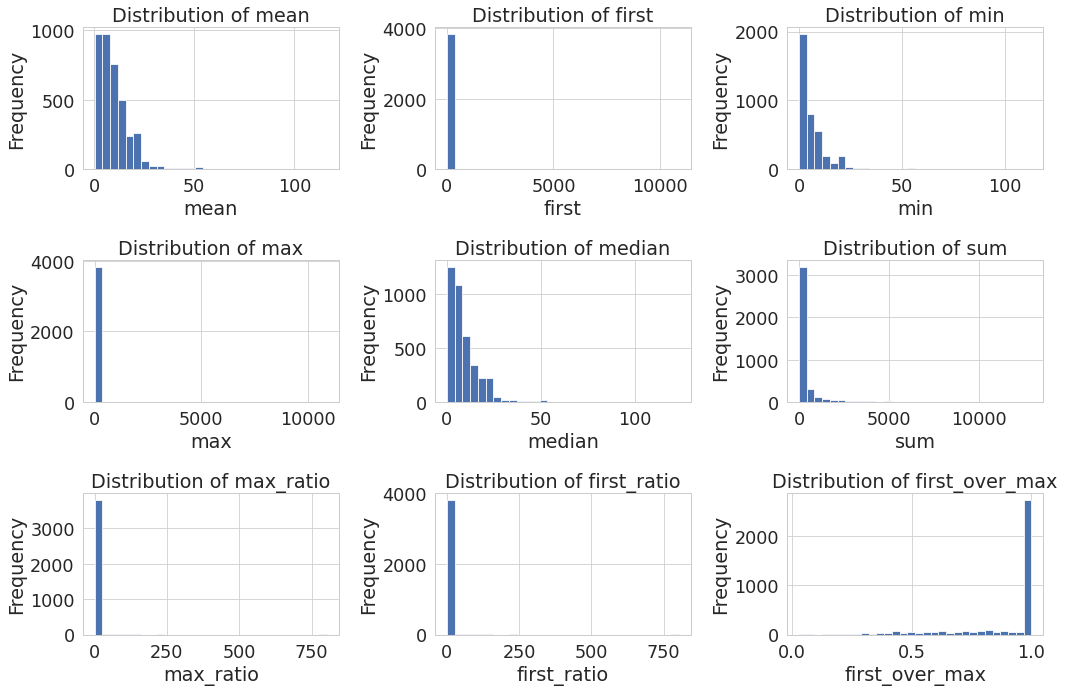

In [51]:
# Get the column names
columns = distance_between_draw.columns

# Create a set of subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Flatten the subplots array
axs = axs.ravel()

# Iterate over the columns and plot the distributions
for i, column in enumerate(columns):
    # Extract the column values
    column_values = distance_between_draw[column]

    # Create a histogram of the column values
    axs[i].hist(column_values, bins=30)

    # Add labels and title to the plot
    axs[i].set_xlabel(column)
    axs[i].set_ylabel("Frequency")
    axs[i].set_title(f"Distribution of {column}")

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

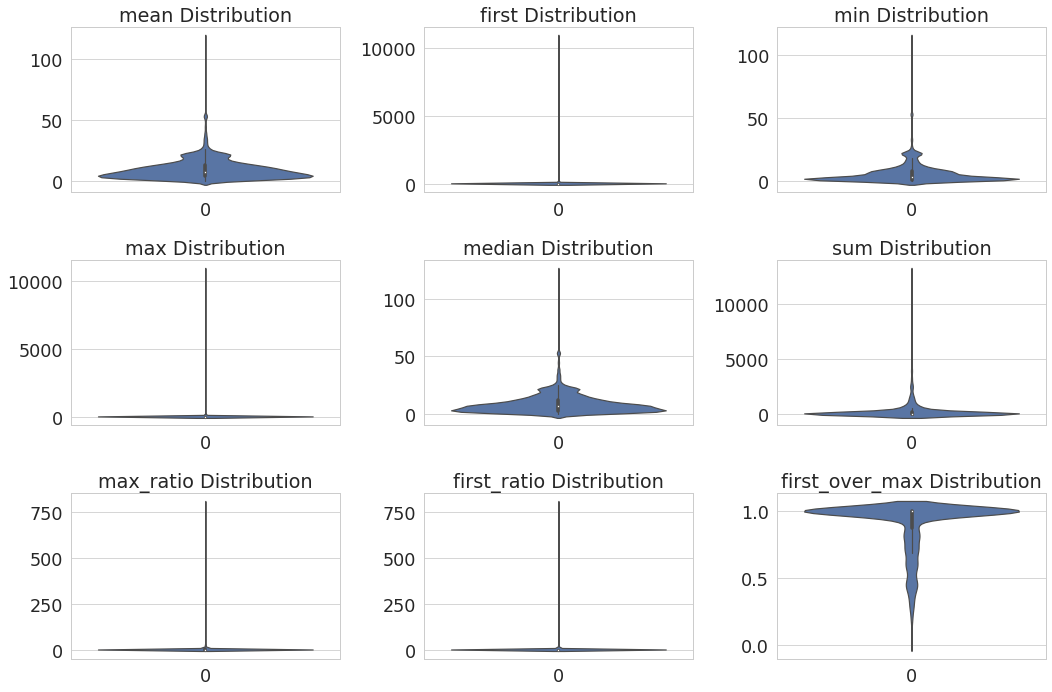

In [52]:
# Get the column names
columns = distance_between_draw.columns

# Create a set of subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Flatten the subplots array
axs = axs.ravel()

# Iterate over the columns and plot the distributions
for i, column in enumerate(columns):
    # Extract the column values
    column_values = distance_between_draw[column]

    # Create a violin plot of the column values
    sns.violinplot(data=column_values, inner="box", ax=axs[i])

    # Set the title of the subplot
    axs[i].set_title(f"{column} Distribution")

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

In [53]:
((distance_between_draw['first_ratio'] >= 2)).sum() / len(distance_between_draw)

0.2768831168831169

In [54]:
distance_between_draw.sort_values(by='first_ratio', ascending=False).head(10)

,mean,first,min,max,median,sum,max_ratio,first_ratio,first_over_max
2483,2.775593,2232,1,2232,1.0,4094,803.607230,803.607230,1.0
599,49.646154,10891,6,10891,8.0,12908,218.528742,218.528742,1.0
2341,9.038760,1313,1,1313,7.0,5830,145.038079,145.038079,1.0
654,0.248566,30,0,30,0.0,130,120.692308,120.692308,1.0
1144,4.046154,377,2,377,2.0,789,93.174905,93.174905,1.0
1606,2.461207,181,0,181,2.0,1142,73.382662,73.382662,1.0
138,2.662309,183,1,183,2.0,1222,68.587561,68.587561,1.0
1190,6.874459,449,3,449,8.0,3176,65.172859,65.172859,1.0
801,2.881188,183,1,183,2.0,1455,63.389691,63.389691,1.0
715,2.972973,183,1,183,2.0,1100,61.388182,61.388182,1.0


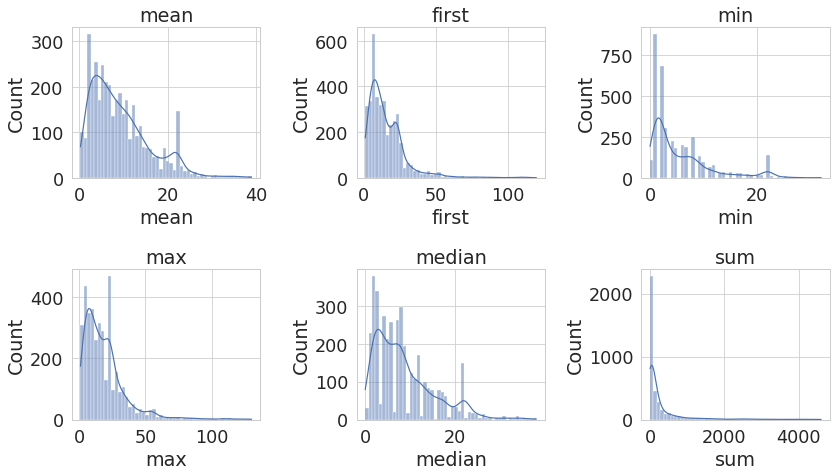

In [55]:
# Get the column names
columns = distance_between_draw.columns

# Create a set of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))

# Flatten the subplots array
axs = axs.ravel()

# Iterate over the columns and plot the distributions
for i, column in enumerate(columns[:6]):
    # Extract the column values
    column_values = distance_between_draw[column]
    # filter > 80%
    column_values = column_values[column_values < column_values.quantile(0.99)]

    # Create a violin plot of the column values
    sns.histplot(column_values, ax=axs[i], kde=True, bins=50)

    # Set the title of the subplot
    axs[i].set_title(f"{column}")

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.savefig('fig/results_spector.pdf', format="pdf", bbox_inches="tight")